##掛載雲端硬碟


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 下載 Colab上沒有的套件


In [13]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-ah5sssp1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-ah5sssp1
  Resolved https://github.com/facebookresearch/detectron2.git to commit b1c43ffbc995426a9a6b5c667730091a384e0fa4
  Preparing metadata (setup.py) ... done


In [14]:
!pip install opencv-python

## Import library

In [15]:
import os
import json
import random
import datetime
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T

## 基礎工具設定



In [16]:
# 初始化 Detectron2 的日誌記錄功能
setup_logger()

def check_device():
    """檢查存在的計算裝置，使用GPU或CPU。"""
    if torch.cuda.is_available():
        print(f"可用的 GPU 數量: {torch.cuda.device_count()}")
        for i in range(torch.cuda.device_count()):
            print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

        # 選擇 GPU（index）進行計算
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
        print(f"當前使用的 GPU 是: {torch.cuda.current_device()}")
    else:
        print("沒有可用的 GPU，使用 CPU 進行計算")
        device = torch.device("cpu")
    return device

def imshow(img):
    """顯示圖片用"""
    plt.figure(figsize=(16, 9))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

## 檢查GPU


In [17]:
DEVICE = check_device()

可用的 GPU 數量: 1
GPU 0: Tesla T4
當前使用的 GPU 是: 0


In [18]:
import os
zip_path = "/content/drive/MyDrive/data.zip"
output_dir = "/content/data"

# unzip
!unzip -q "$zip_path" -d "$output_dir"

In [19]:
import os
import json
import random

def convert_to_coco(input_files, output_path):
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": [
            {"id": 1, "name": "flower"},
            {"id": 2, "name": "pot"},
            {"id": 3, "name": "bud"},
        ],
    }

    annotation_counter = 1  # Annotation counter
    image_counter = 1     # Image counter

    def get_category_id(category_name):
        """Helper function to retrieve category ID."""
        return next((cat["id"] for cat in coco_data["categories"] if cat["name"] == category_name), None)

    def extract_points(shape):
        """Extract and flatten points from a shape."""
        return [coord for point in shape["points"] for coord in point]

    def compute_bbox(points):
        """Calculate the bounding box from the polygon points."""
        x_coords = [p[0] for p in points]
        y_coords = [p[1] for p in points]
        x_min, y_min = min(x_coords), min(y_coords)
        x_max, y_max = max(x_coords), max(y_coords)
        return [x_min, y_min, x_max - x_min, y_max - y_min]

    # Iterate over input files
    for file_path in input_files:
        with open(file_path, "r") as f:
            data = json.load(f)

        # Image data extraction
        file_name = os.path.basename(file_path).replace(".json", ".png")
        width, height = 1000, 1000

        # Add image entry to COCO format
        coco_data["images"].append({
            "id": image_counter,
            "file_name": os.path.join("/content/data/data", file_name),
            "width": width,
            "height": height,
        })

        # Process each shape in the current JSON file
        for shape in data["shapes"]:
            category_id = get_category_id(shape["label"])
            if category_id is None:
                continue  # Skip shapes with undefined categories

            points = shape["points"]
            segmentation = extract_points(shape)
            bbox = compute_bbox(points)
            area = bbox[2] * bbox[3]  # Width * Height

            # Add annotation entry to COCO format
            coco_data["annotations"].append({
                "id": annotation_counter,
                "image_id": image_counter,
                "category_id": category_id,
                "segmentation": [segmentation],
                "bbox": bbox,
                "area": area,
                "iscrowd": 0,
            })
            annotation_counter += 1

        image_counter += 1

    # Save COCO format data to output file
    with open(output_path, "w") as f:
        json.dump(coco_data, f, indent=4)

    print(f"COCO file saved to {output_path}")

# Directories and output paths
data_dir = "/content/data/data"
output_paths = {
    "train": "./data/train_coco_format.json",
    "val": "./data/val_coco_format.json",
    "test": "./data/test_coco_format.json",
}

# Get all JSON files in the directory
json_files = [os.path.join(data_dir, file) for file in os.listdir(data_dir) if file.endswith(".json")]

# Shuffle and split files into train, validation, and test sets 7:2:1
random.shuffle(json_files)
train_files, val_files, test_files = (
    json_files[:int(0.7 * len(json_files))],
    json_files[int(0.7 * len(json_files)):int(0.9 * len(json_files))],
    json_files[int(0.9 * len(json_files)):],
)

# Convert and save each set
convert_to_coco(train_files, output_paths["train"])
convert_to_coco(val_files, output_paths["val"])
convert_to_coco(test_files, output_paths["test"])


COCO file saved to ./data/train_coco_format.json
COCO file saved to ./data/val_coco_format.json
COCO file saved to ./data/test_coco_format.json


#Prepare dataset

Regist dataset

* 參考連結：https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html

In [20]:
from detectron2.data.datasets import register_coco_instances

# 設定檔案路徑
train_ann_path = r'./data/train_coco_format.json'
train_img_path = r'./data/'
valid_ann_path = r'./data/val_coco_format.json'
valid_img_path = r'./data/'
test_ann_path = r'./data/test_coco_format.json'
test_img_path = r'./data/'

assert os.path.isfile(train_ann_path), f'Training annotation file not found: {train_ann_path}'
assert os.path.isdir(train_img_path), f'Training image directory not found: {train_img_path}'
assert os.path.isfile(valid_ann_path), f'Validation annotation file not found: {valid_ann_path}'
assert os.path.isdir(valid_img_path), f'Validation image directory not found: {valid_img_path}'
assert os.path.isfile(test_ann_path), f'Test annotation file not found: {test_ann_path}'
assert os.path.isdir(test_img_path), f'Test image directory not found: {test_img_path}'

# 資料註冊
"""
請同學完成train、val、test資料的設定(請避免用重複名稱進行註冊)
"""
#train資料註冊
register_coco_instances("train_ds", {}, train_ann_path, train_img_path)

#val資料註冊
register_coco_instances("val_ds", {}, valid_ann_path, valid_img_path)

#test資料註冊
register_coco_instances("test_ds", {}, test_ann_path, test_img_path)

Get categories



In [21]:
# 取得類別
dataset_dicts = DatasetCatalog.get("train_ds") # (""中的內容依照註冊的train資料集名稱進行設置)
orchid_metadata = MetadataCatalog.get("train_ds") # (""中的內容依照註冊的train資料集名稱進行設置)
print(f'要辨識的內容：{orchid_metadata.thing_classes}')

[01/06 13:30:20 d2.data.datasets.coco]: Loaded 580 images in COCO format from ./data/train_coco_format.json
要辨識的內容：['flower', 'pot', 'bud']


Show some samples


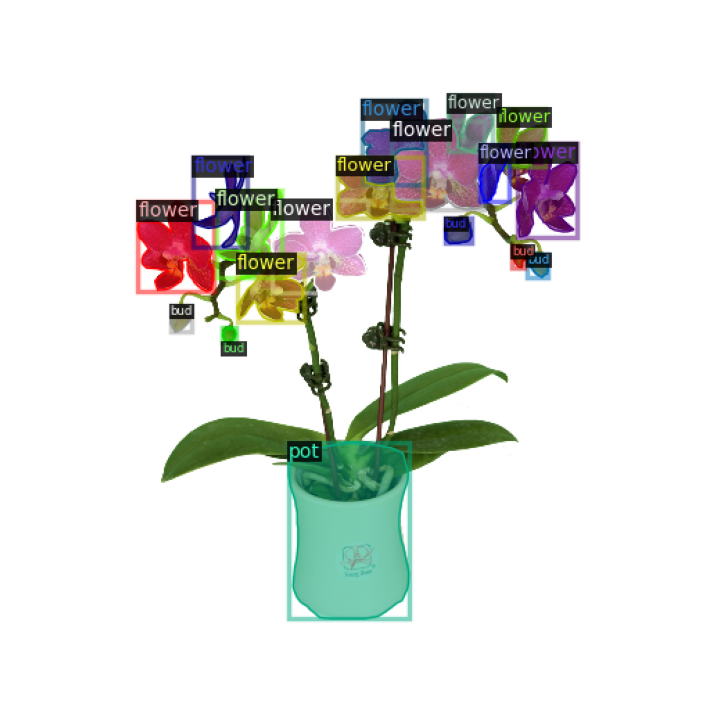

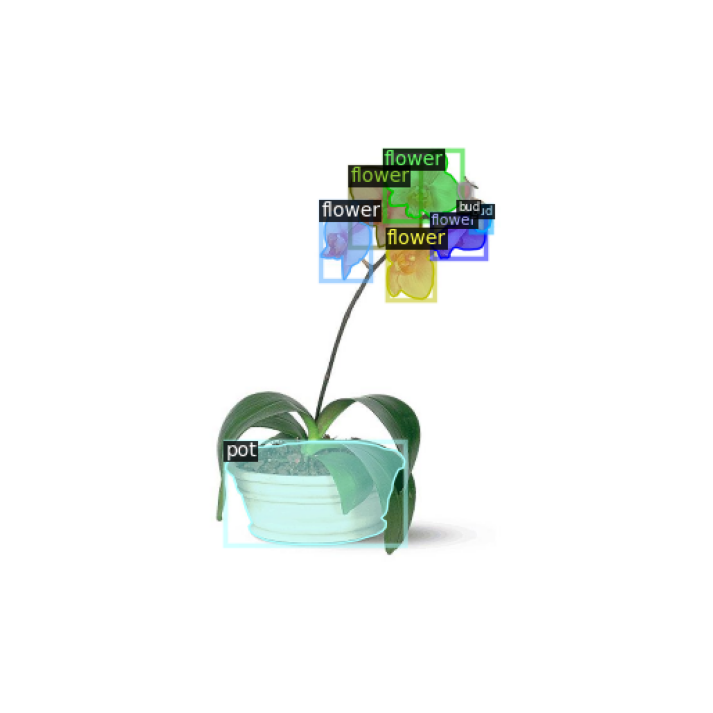

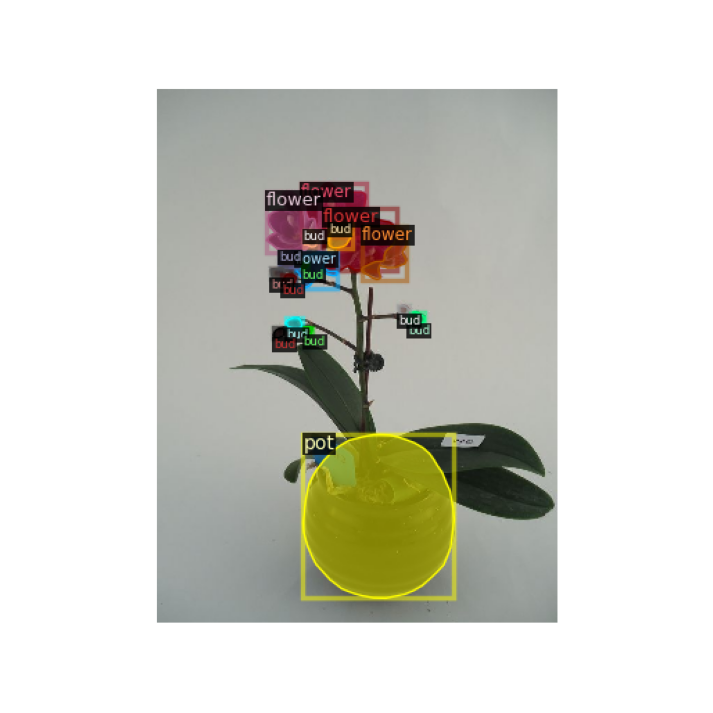

In [22]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=orchid_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    imshow(out.get_image())

#Build trainer


*   功能： 自訂訓練流程。DefaultTrainer 是 Detectron2 提供的一個方便類別，包含了預設的模型訓練邏輯。
*   為什麼要自訂？ 預設的 DefaultTrainer 在進行評估（evaluation）時，僅使用內建邏輯。自訂 MyTrainer 可以更靈活地定義如何執行評估。



In [23]:
from detectron2.data import build_detection_train_loader

# 建立 trainer (可根據需求去做修改)
class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        """
        定義評估器
        """
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [24]:
# 下載模型
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl

--2025-01-06 13:30:22--  https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.124, 108.157.254.102, 108.157.254.121, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254055290 (242M) [application/octet-stream]
Saving to: ‘model_final_a3ec72.pkl’

model_final_a3ec72. 100%[===================>] 242.29M   185MB/s    in 1.3s    

2025-01-06 13:30:24 (185 MB/s) - ‘model_final_a3ec72.pkl’ saved [254055290/254055290]



#Train loop

mask_rcnn_R_101+FPN

Setup cofig

In [25]:
"""
以下缺失的內容請同學自行補充，可以加其他的內容
"""

# 設定 config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))

# 設定訓練和驗證數據集
cfg.DATASETS.TRAIN = ("train_ds",) # (""中的內容依照註冊的train資料集名稱進行設置)
cfg.DATASETS.TEST = ("val_ds",) # (""中的內容依照註冊的val資料集名稱進行設置)

# 指定模型的初始權重檔案
cfg.MODEL.WEIGHTS = "./model_final_a3ec72.pkl"

# 設定訓練批次大小和資料載入的工作執行緒數量
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.DATALOADER.NUM_WORKERS = 2

# 設定learning rate
cfg.SOLVER.BASE_LR = 0.01

# Epoch = MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES
cfg.SOLVER.MAX_ITER = 100

# 設定驗證頻率
cfg.TEST.EVAL_PERIOD = 50

# 設定模型的輸出類別數
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 #the number of classes

# 設定模型輸出
cfg.OUTPUT_DIR = os.path.join('output', datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))

Train model

In [26]:
# 訓練模型
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

with open(os.path.join(cfg.OUTPUT_DIR, 'output.yaml'), "w") as f:
  f.write(cfg.dump())

# Trained on CPU
#cfg.MODEL.DEVICE = "cpu"

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/06 13:30:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/06 13:30:29 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[01/06 13:31:24 d2.utils.events]:  eta: 0:03:20  iter: 19  total_loss: 2.416  loss_cls: 0.689  loss_box_reg: 0.6322  loss_mask: 0.6397  loss_rpn_cls: 0.1001  loss_rpn_loc: 0.2906    time: 2.5207  last_time: 2.2904  data_time: 0.2923  last_data_time: 0.2274   lr: 0.0019081  max_mem: 9291M
[01/06 13:32:23 d2.utils.events]:  eta: 0:02:36  iter: 39  total_loss: 1.554  loss_cls: 0.3744  loss_box_reg: 0.6295  loss_mask: 0.316  loss_rpn_cls: 0.06175  loss_rpn_loc: 0.2022    time: 2.6300  last_time: 2.8817  data_time: 0.2665  last_data_time: 0.2121   lr: 0.0039061  max_mem: 9394M
[01/06 13:32:51 d2.data.datasets.coco]: Loaded 166 images in COCO format from ./data/val_coco_format.json
[01/06 13:32:51 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   flower   | 1343         |    pot     | 143          |    

Look at training curves in tensorboard

#Inference & evaluation using the train model

In [28]:
# evaluation on validation set
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val_ds", output_dir="./output") # (""中的內容依照註冊的val資料集名稱進行設置)
val_loader = build_detection_test_loader(cfg, "val_ds") # (""中的內容依照註冊的val資料集名稱進行設置)
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[01/06 13:42:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_133024/model_final.pth ...
[01/06 13:42:42 d2.data.datasets.coco]: Loaded 166 images in COCO format from ./data/val_coco_format.json
[01/06 13:42:42 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 13:42:42 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/06 13:42:42 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[01/06 13:42:42 d2.data.common]: Serialized dataset takes 2.46 MiB
[01/06 13:42:42 d2.evaluation.evaluator]: Start inference on 166 batches
[01/06 13:42:44 d2.evaluation.evaluator]: Inference done 11/166. Dataloading: 0.0013 s/iter. Inference: 0.1216 s/iter. Eval: 0.0728 s/iter. Total: 0.1957 s/iter. ETA=0:00:30
[01/06 13:42:49 d2.evaluation.evaluator]: Inf

In [29]:
# evaluation on test set
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("test_ds", output_dir="./output") # (""中的內容依照註冊的test資料集名稱進行設置)
test_loader = build_detection_test_loader(cfg, "test_ds") # (""中的內容依照註冊的test資料集名稱進行設置)
print(inference_on_dataset(predictor.model, test_loader, evaluator))


[01/06 13:46:37 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_133024/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/06 13:46:38 d2.data.datasets.coco]: Loaded 83 images in COCO format from ./data/test_coco_format.json
[01/06 13:46:38 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   flower   | 657          |    pot     | 72           |    bud     | 325          |
|            |              |            |              |            |              |
|   total    | 1054         |            |              |            |              |
[01/06 13:46:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 13:46:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/06 13:46:38 d2.data.common]: Serializing 83 elements to byte tensors and concaten

## 測試資料辨識嘗試(只需要保留一種架構的輸出結果)

[01/06 13:49:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_133024/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

./data/data/D0680.png


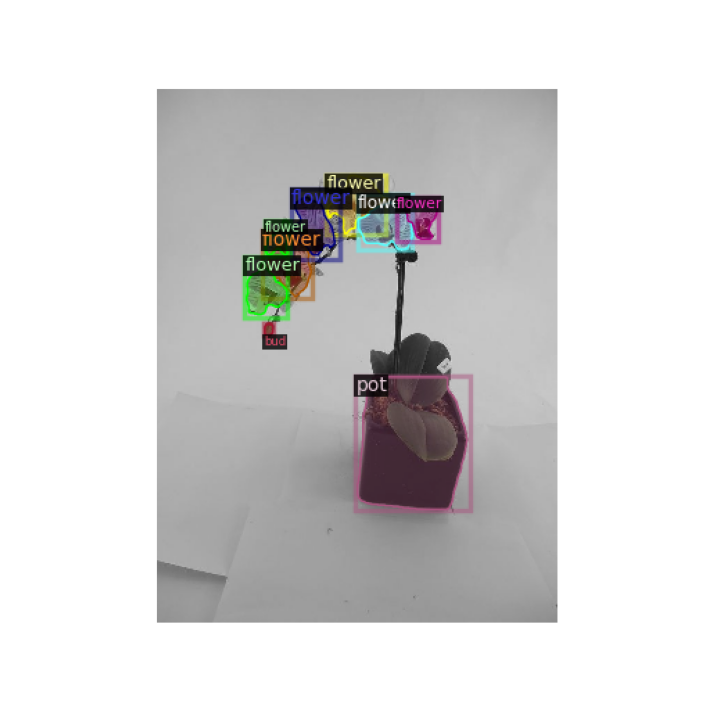

./data/data/D0344.png


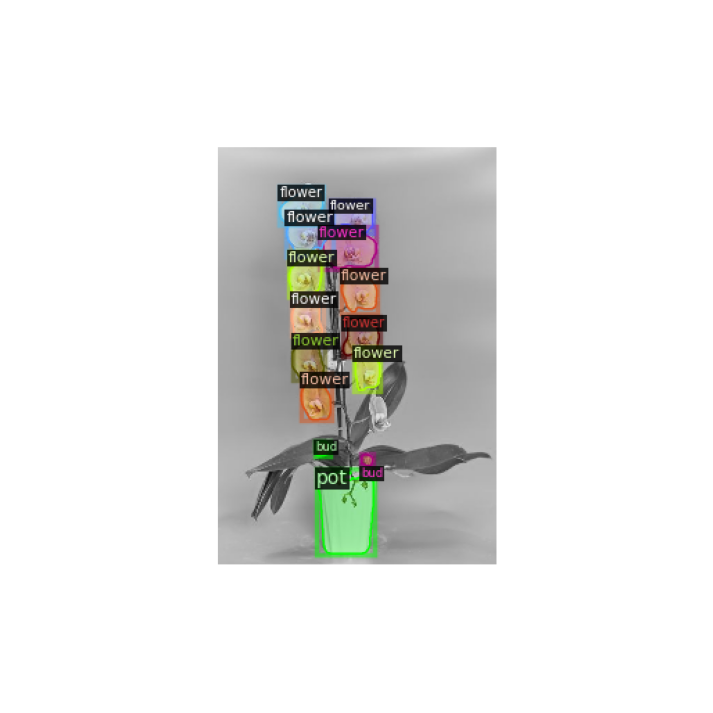

./data/data/D0370.png


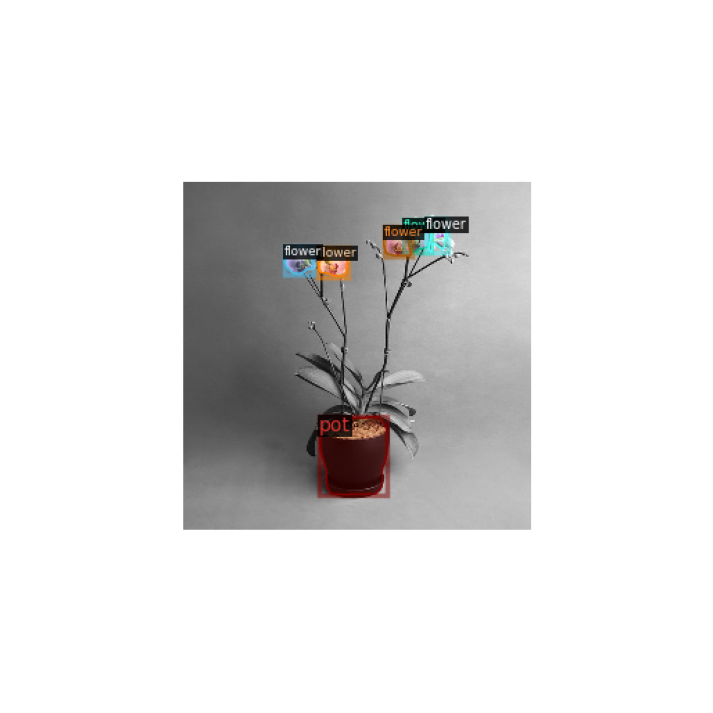

./data/data/D0027.png


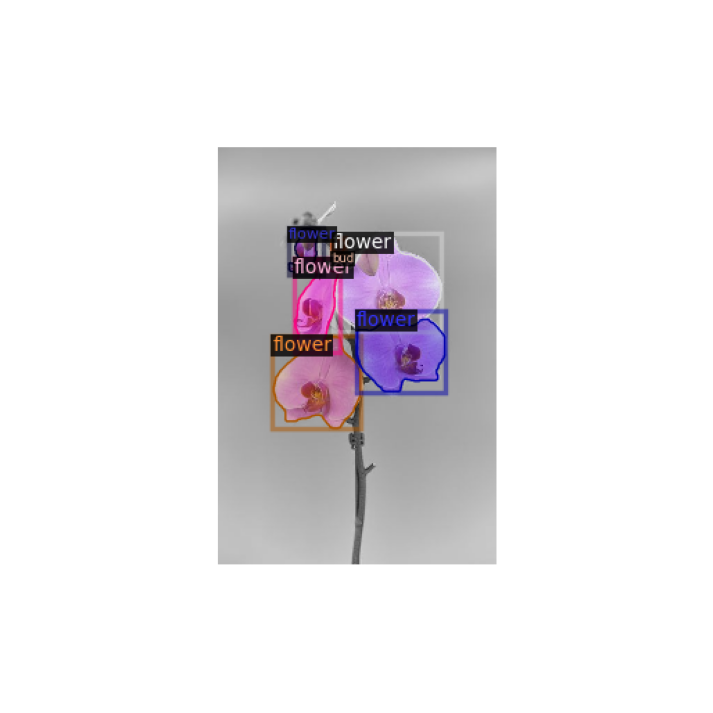

./data/data/D0469.png


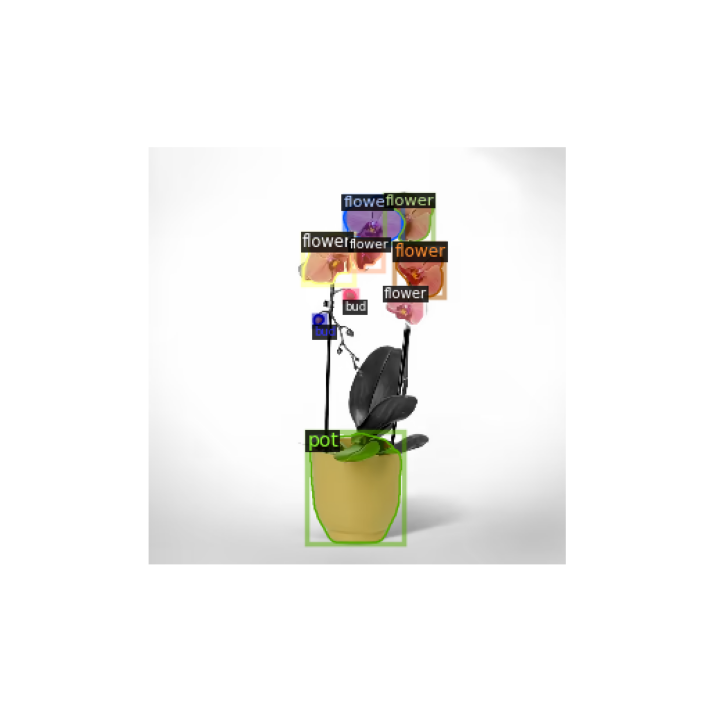

./data/data/D0252.png


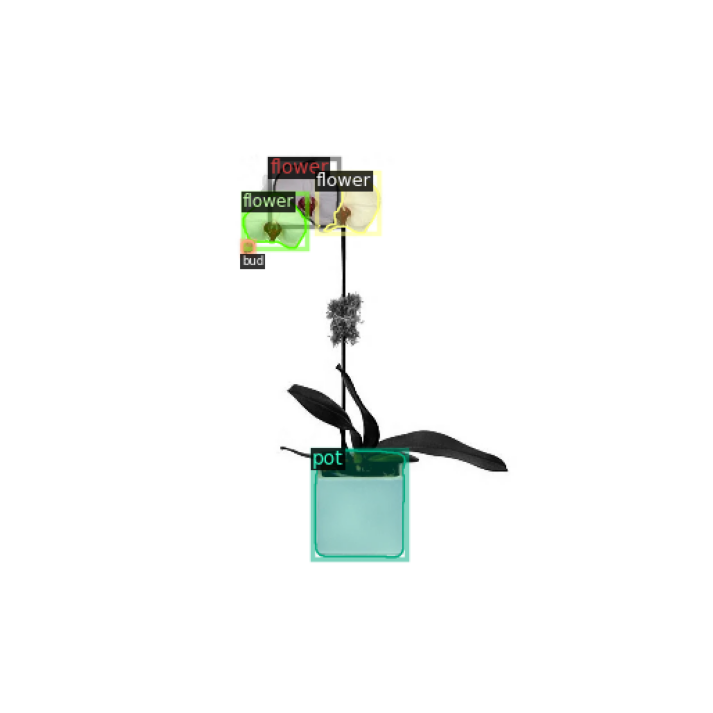

./data/data/D0475.png


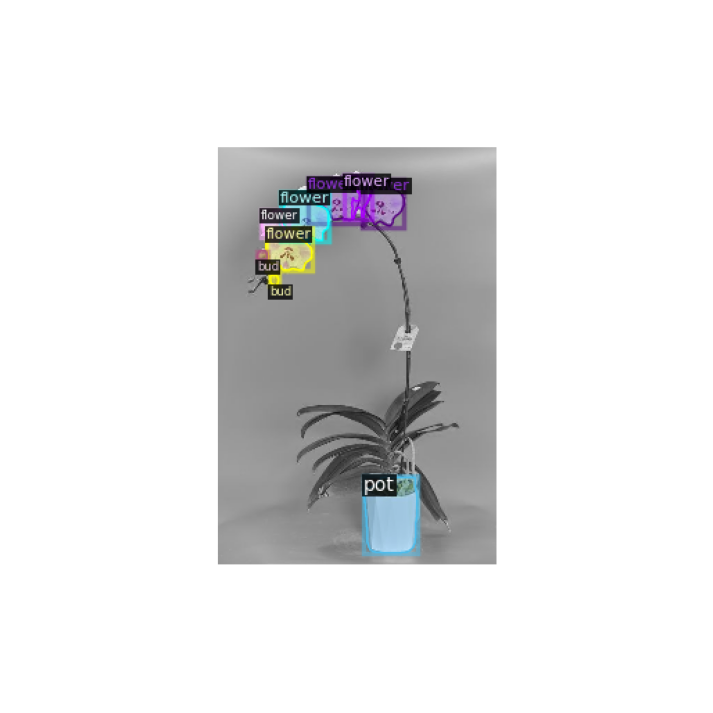

./data/data/D0444.png


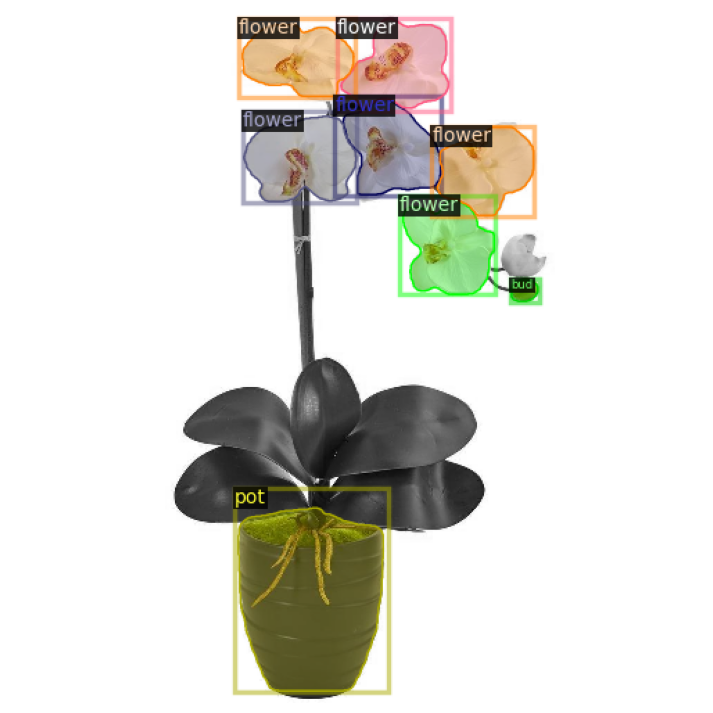

./data/data/D0106.png


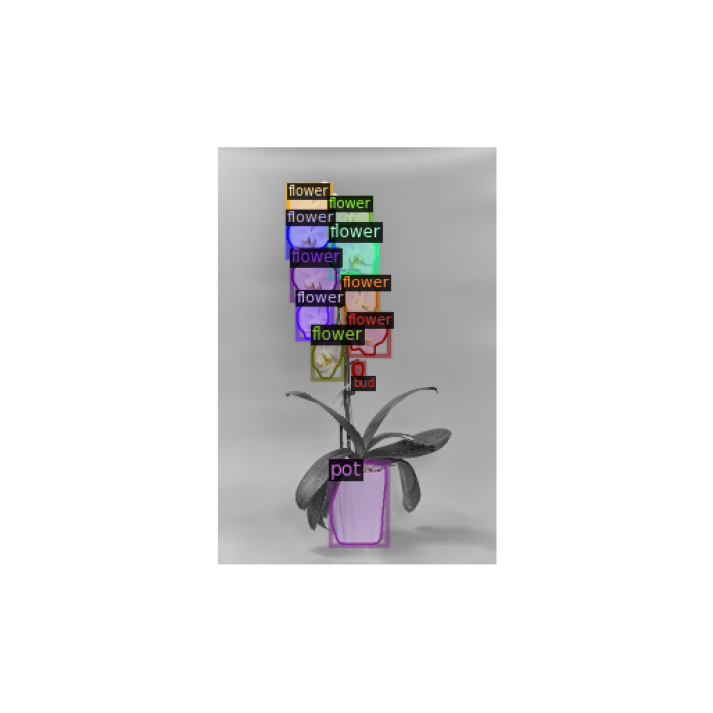

./data/data/D0058.png


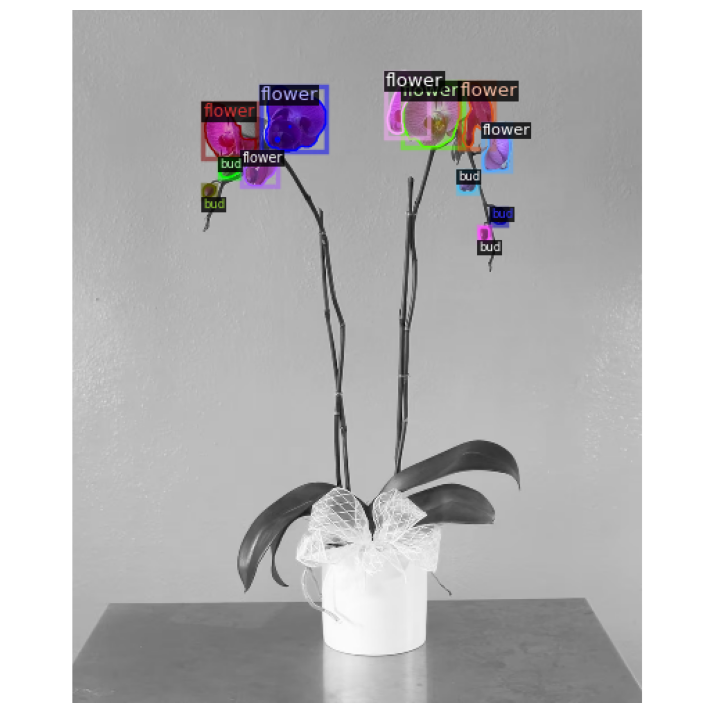

In [31]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set a custom testing threshold

predictor = DefaultPredictor(cfg)

#設置檔案路徑
test_dir = r"./data/data"

# 定義支援的圖片格式
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp')

# 從 test_dir 中選取以 .jpg 結尾的檔案
jpg_files = [file for file in os.listdir(test_dir) if file.endswith(image_extensions)]

# 隨機選取 10 個 .jpg 檔案
for file_name in random.sample(jpg_files, 10):
  test_file_path = os.path.join(test_dir, file_name)
  print(test_file_path)
  im = cv2.imread(test_file_path)

  outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format


  # 移除標籤、分數的顯示(根據需求調整)
  instances = outputs["instances"].to("cpu")
  instances.remove('scores')
  # instances.remove('pred_classes')

  # 使用Visualizer生成可視化輸出
  v = Visualizer(im[:, :, ::-1],
                   metadata=orchid_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW  # remove the colors of unsegmented pixels. This option is only available for segmentation models
                   )
  out = v.draw_instance_predictions(instances)
  output_image = out.get_image()

  # 顯示圖像
  imshow(output_image)

mask_rcnn_R_50+FPN

In [32]:
import os
import datetime
from detectron2.config import get_cfg
from detectron2 import model_zoo

# 設定 config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# 設定訓練和驗證數據集
cfg.DATASETS.TRAIN = ("train_ds",)  # 根據註冊的訓練資料集名稱進行設置
cfg.DATASETS.TEST = ("val_ds",)    # 根據註冊的驗證資料集名稱進行設置

# 指定模型的初始權重檔案
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# 設定訓練批次大小和資料載入的工作執行緒數量
cfg.SOLVER.IMS_PER_BATCH = 8  # 訓練批次大小
cfg.DATALOADER.NUM_WORKERS = 2  # 資料載入的工作執行緒數量

# 設定 learning rate
cfg.SOLVER.BASE_LR = 0.01

# 計算並設定最大迭代次數 (MAX_ITER)
# Epoch = MAX_ITER * BATCH_SIZE / TOTAL_NUM_IMAGES
cfg.SOLVER.MAX_ITER = 100

# 設定驗證頻率
cfg.TEST.EVAL_PERIOD = 50

# 設定模型的輸出類別數 (注意要包含背景類別，若無背景，僅設為目標類別數)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # 類別數量

# 設定模型輸出目錄
cfg.OUTPUT_DIR = os.path.join('output', datetime.datetime.now().strftime('%Y%m%d_%H%M%S'))

# 確認輸出資料夾存在
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# 印出設定確認
print("Config: \n", cfg.dump())

Config: 
 CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_SQRT: true
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST:
  - val_ds
  TRAIN:
  - train_ds
FLOAT32_PRECISION: ''
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE

In [33]:
# 訓練模型
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

with open(os.path.join(cfg.OUTPUT_DIR, 'output.yaml'), "w") as f:
  f.write(cfg.dump())

# Trained on CPU
#cfg.MODEL.DEVICE = "cpu"

trainer = MyTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/06 14:13:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 187MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[01/06 14:13:13 d2.engine.train_loop]: Starting training from iteration 0
[01/06 14:13:57 d2.utils.events]:  eta: 0:02:57  iter: 19  total_loss: 2.535  loss_cls: 0.7663  loss_box_reg: 0.7176  loss_mask: 0.6438  loss_rpn_cls: 0.1012  loss_rpn_loc: 0.2511    time: 2.2475  last_time: 2.1720  data_time: 0.2762  last_data_time: 0.2078   lr: 0.0019081  max_mem: 9441M
[01/06 14:14:43 d2.utils.events]:  eta: 0:02:12  iter: 39  total_loss: 1.764  loss_cls: 0.4369  loss_box_reg: 0.7456  loss_mask: 0.3186  loss_rpn_cls: 0.05547  loss_rpn_loc: 0.2127    time: 2.2566  last_time: 2.2487  data_time: 0.2623  last_data_time: 0.2204   lr: 0.0039061  max_mem: 9441M
[01/06 14:15:05 d2.data.datasets.coco]: Loaded 166 images in COCO format from ./data/val_coco_format.json
[01/06 14:15:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 14:15:05 d2.data.common]: Serializing the dataset usi

In [34]:
# evaluation on validation set
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("val_ds", output_dir="./output") # (""中的內容依照註冊的val資料集名稱進行設置)
val_loader = build_detection_test_loader(cfg, "val_ds") # (""中的內容依照註冊的val資料集名稱進行設置)
print(inference_on_dataset(predictor.model, val_loader, evaluator))

[01/06 14:19:27 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_141201/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[01/06 14:19:28 d2.data.datasets.coco]: Loaded 166 images in COCO format from ./data/val_coco_format.json
[01/06 14:19:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 14:19:28 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/06 14:19:28 d2.data.common]: Serializing 166 elements to byte tensors and concatenating them all ...
[01/06 14:19:28 d2.data.common]: Serialized dataset takes 2.46 MiB
[01/06 14:19:28 d2.evaluation.evaluator]: Start inference on 166 batches
[01/06 14:19:30 d2.evaluation.evaluator]: Inference done 11/166. Dataloading: 0.0020 s/iter. Inference: 0.0952 s/iter. Eval: 0.0996 s/iter. Total: 0.1968 s/iter. ETA=0:00:30
[01/06 14:19:36 d2.evaluation.evaluator]: Inference done 32/166. Dataloading: 0.0046 s/iter. Inference: 0.1052 s/iter. Eval: 0.1223 s/iter. Total: 0.2324 s/iter. ETA=0:00:31
[01/

In [36]:
# evaluation on test set
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
predictor = DefaultPredictor(cfg)

evaluator = COCOEvaluator("test_ds", output_dir="./output") # (""中的內容依照註冊的test資料集名稱進行設置)
test_loader = build_detection_test_loader(cfg, "test_ds") # (""中的內容依照註冊的test資料集名稱進行設置)
print(inference_on_dataset(predictor.model, test_loader, evaluator))


[01/06 14:20:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/20250106_141201/model_final.pth ...
[01/06 14:20:58 d2.data.datasets.coco]: Loaded 83 images in COCO format from ./data/test_coco_format.json
[01/06 14:20:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/06 14:20:58 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[01/06 14:20:58 d2.data.common]: Serializing 83 elements to byte tensors and concatenating them all ...
[01/06 14:20:58 d2.data.common]: Serialized dataset takes 1.17 MiB
[01/06 14:20:58 d2.evaluation.evaluator]: Start inference on 83 batches
[01/06 14:21:00 d2.evaluation.evaluator]: Inference done 11/83. Dataloading: 0.0035 s/iter. Inference: 0.0970 s/iter. Eval: 0.0927 s/iter. Total: 0.1932 s/iter. ETA=0:00:13
[01/06 14:21:05 d2.evaluation.evaluator]: Infere